# Rosenblatt Perceptron

In this notebook I try to implement the Rosenblatt Perceptron in plain numpy. The foundation research paper you will find here: https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf 

The perceptron is described in four steps. I will iterate through the steps and develop the code step by step.



![Fig 1. Organization of a perceptron](https://www.researchgate.net/publication/328966158/figure/fig1/AS:693278764707841@1542301946487/The-original-perceptron-concept-from-Rosenblatt-ref-7-public-domain-artificial.png)  
FIG. 1. Organization of a perceptron.

**Perceptron forward pass**

1. Transofrm the signal
   - Stimulis on a retina are captured as a *all or nothing signal* which I interpret as a binary signal. In the example here we transform some numbers of the mnist dataset into this form of a signal.
   - This signal has  random connections to the association matrix (weights); (I implemented this as a matrix multiplication with random binary values on the diagonal). But "This projection area may be omitted in some models, where the retina is connected directly to the association area (An)" see Rosenblatt et al 1958, p.386. Because I observed in tests a slightly better performance without the projection area, I will omit it here.
2. multiply the signal with the weights
3. add bias
4. apply the activation function


**Perceptron Learning Rule**  

1. Get the perceptron prediction (forwardpass)
2. Compute the error, i.e. the difference between the prediction and the target
3. Multiply each input value by the error (and the learning rate) and add it to the weight 
4. Add the error to the bias


In [54]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from src.utils.load_data import mnist
from src.utils.plot import plot_examples, plot_metrics

%config InlineBackend.figure_format='retina'

train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



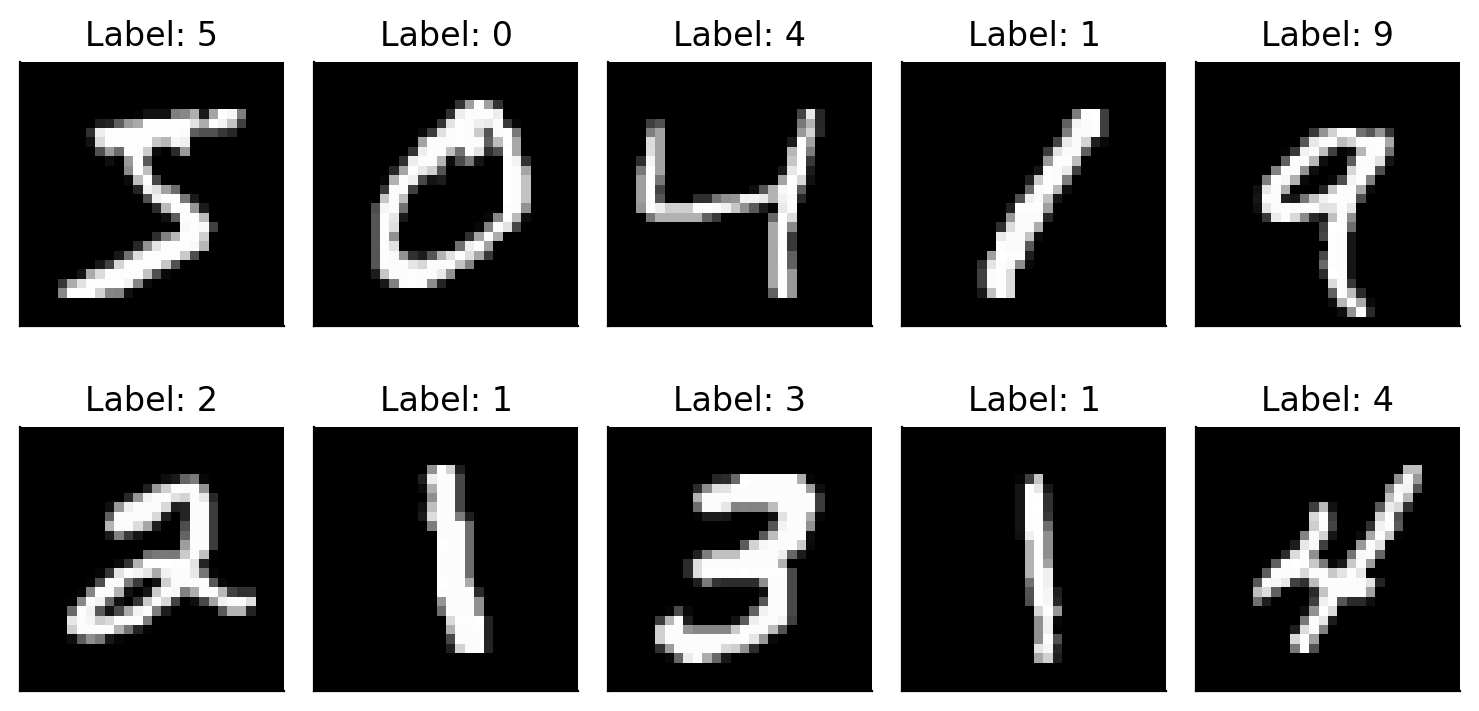

In [55]:
# inspect image data as it is
plot_examples(train_images, train_labels)

In [56]:
binary_compare_labels = [4, 9]

idx2label = dict(enumerate(binary_compare_labels))
label2idx = {label: i for i, label in idx2label.items()}
binary_index = np.isin(train_labels, binary_compare_labels)
binary_train_labels = train_labels[binary_index]
binary_train_images = train_images[binary_index]

In [57]:
# Normalize the data first between 0 and 1


def normalize(
    X: np.ndarray[np.ndarray[np.ndarray[np.float32]]], x_min: float, x_max: float
) -> np.ndarray[np.ndarray[np.ndarray[np.float32]]]:
    """normalize normalizes the values of the input arrays between x_min and x_max.

    Args:
        X (np.ndarray): image data as np.ndarrays
        x_min (float): min value of the transformed input array
        x_max (float): max value of the transformed input array

    Returns:
        np.ndarray: transformed input array
    """

    nom = (X - X.min(axis=0)) * (x_max - x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom == 0] = 1
    return x_min + nom / denom

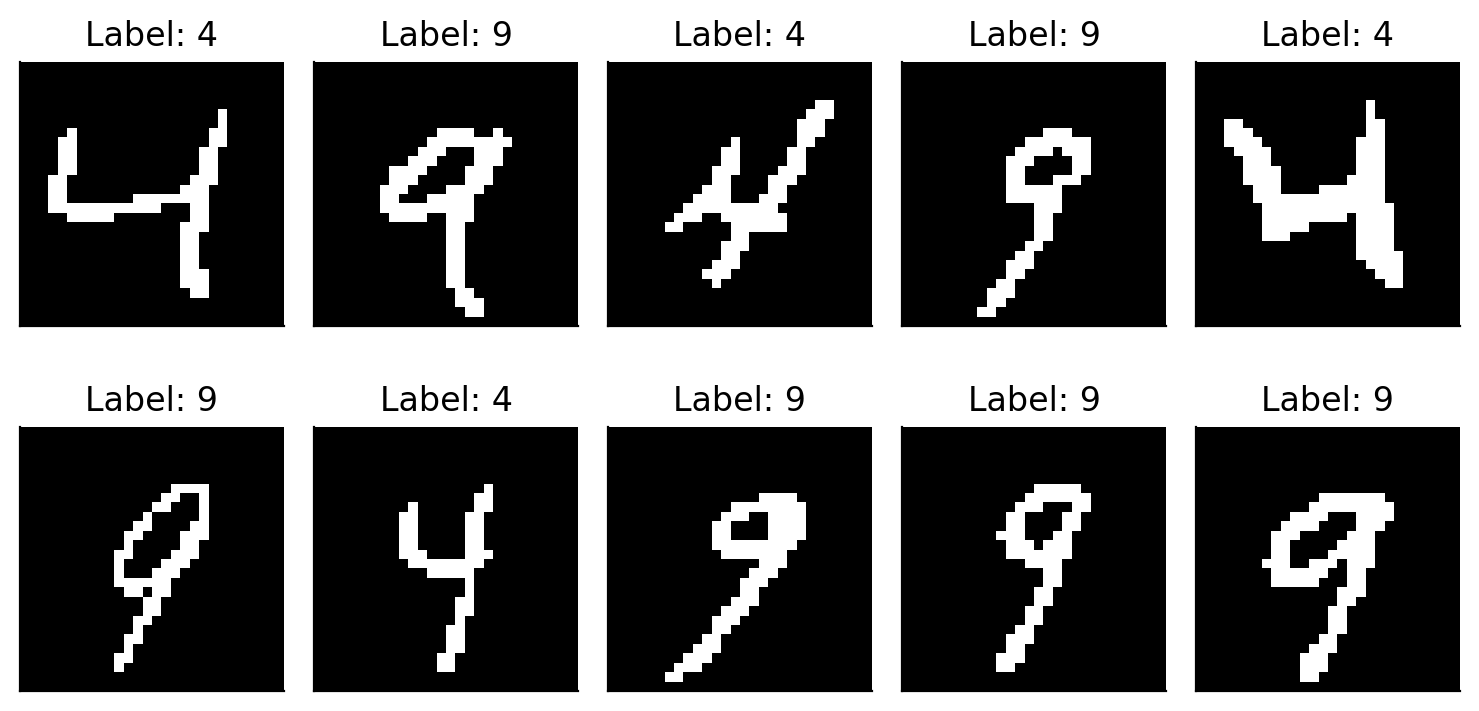

In [58]:
# inspect several transformed images, normalized between 0 and 1 and then rounded to a integer.
plot_examples(
    normalize(binary_train_images, 0, 1).round(decimals=0), binary_train_labels
)

The plot obove shows the images converted to a binary signal. This signal is then used as input to the perceptron.

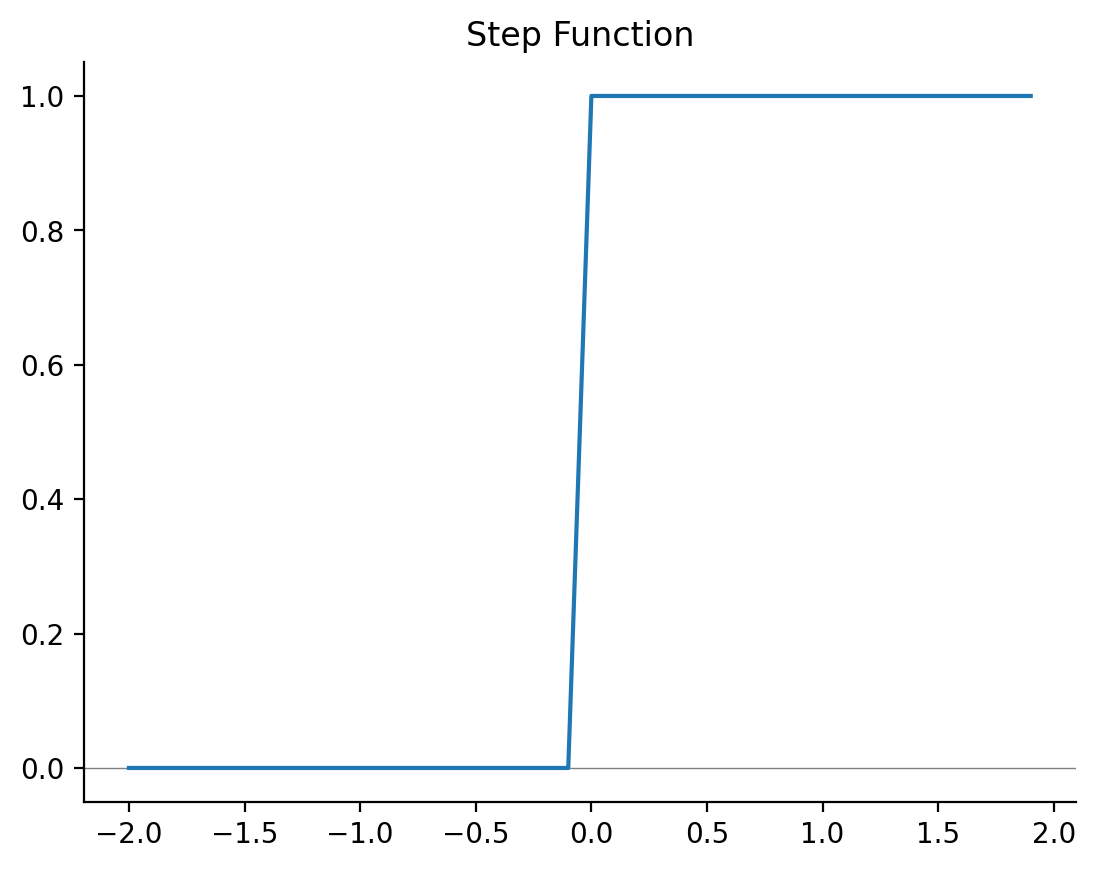

In [59]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# activation function is the step function


def step_function(x: np.ndarray, threshold: float = 0.0) -> np.ndarray:
    """step_function applies the step activation function to the input array.

    Args:
        x (np.ndarray): input array
        threshold (float, optional): threshold value for the step function. Defaults to 0.0.

    Returns:
        np.ndarray: transformed input array, where values greater than the threshold are set to 1, and others to 0.
    """
    return np.where(x > threshold, 1, 0)


# inspect the step activation function
input = np.arange(-2.0, 2.0, 0.1)

plt.axhline(0, color="gray", linewidth=0.5)
plt.plot(input, step_function(input))
plt.title("Step Function")
plt.show()

In [ ]:
def compute_weighted_sum(
    X_transformed: np.ndarray, weights: np.ndarray, bias_size: int = 1
) -> np.ndarray:
    """computes the weighted sum of the input array and the weights + bias.
    Args:
        X_transformed (np.ndarray): transformed input array
        weights (np.ndarray): weights of the perceptron
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        np.ndarray: weighted sum of the input array and the weights + bias
    """
    # return np.matmul(X_transformed, weights[:-bias_size]) + weights[-bias_size]
    return X_transformed @ weights[:-bias_size] + weights[-bias_size]


In [ ]:
# Forward pass

w_len = binary_train_images[0].flatten().shape[0]
bias_size = 1

weights = np.zeros(w_len + bias_size)


def predict(
    transformed_image: np.ndarray,
    weights: np.ndarray,
    bias_size: int = 1,
    backward=False,
) -> int:
    """
    Perform a forward pass through the perceptron.

    Args:
        transformed_image (np.ndarray): The input image after transformation.
        weights (np.ndarray): The weights of the perceptron.
        bias_size (int): The size of the bias term.
        backward (bool): If True, return idx otherwise return the label.

    Returns:
        int: The prediction made by the perceptron.
    """
    # apply random conections from the input to the assosciated weights

    # binary classifier case
    if len(weights.shape) == 1:
        # Calculate the weighted sum of inputs and weights
        weighted_sum = compute_weighted_sum(transformed_image, weights, bias_size)

        # Apply the activation function
        preds = step_function(weighted_sum, 0)
        return preds if backward else idx2label.get(preds.item())

    # Multiclass case
    else:
        preds = np.zeros(weights.shape[0])

        # Calculate the weighted sum of inputs and weights for each class
        for i in range(weights.shape[0]):
            weighted_sum = compute_weighted_sum(
                transformed_image, weights[i], bias_size
            )

            # Apply the activation function add the result to the predictions
            preds[i] = step_function(weighted_sum, 0)

        # Return the index of the class with the highest prediction
        return np.argmax(preds)


# inspect the prediction of the neural network#transform the image
transformed_image = normalize(binary_train_images[0], 0, 1).round(decimals=0).flatten()
predicted_value = predict(transformed_image, weights)
print(predicted_value)

4


In [ ]:
# backward pass


def backward_pass(
    transformed_image: np.ndarray,
    weights: np.ndarray,
    label: int,
    learning_rate: float = 0.1,
    bias_size: int = 1,
) -> Tuple[np.ndarray, float]:
    """
    Perform a backward pass through the neural network.

    Args:
        transformed_image (np.ndarray): The input image after transformation.
        weights (np.ndarray): The weights of the neural network.
        label (int): The true label of the image.
        learning_rate (float, optional): The learning rate for weight updates.
        bias_size (int, optional): amount of additional weights for the bias term. Defaults to 1.

    Returns:
        Tuple[np.ndarray, float]: Updated weights and the error.
    """

    # Forward pass
    prediction = predict(transformed_image, weights, bias_size, backward=True)

    # Binary classifier case
    if len(weights.shape) == 1:
        # Calculate the error
        error = label2idx.get(label) - prediction

        # Update weights and bias
        weights[:-bias_size] += learning_rate * error * transformed_image
        weights[-bias_size] += learning_rate * error

        loss = abs(error)

    # Multiclass case
    else:
        loss = 0
        if prediction != label:
            # Calculate the error
            loss = 1

            # update the weights
            # first decrease the weights for the misclassified class as the error is 1, we don't need to multiply with the error
            weights[prediction][:-bias_size] -= learning_rate * transformed_image
            weights[prediction][-bias_size] -= learning_rate
            # then increase the weights for the correct class
            weights[label][:-bias_size] += learning_rate * transformed_image
            weights[label][-bias_size] += learning_rate

    return weights, loss


# Example usage
new_weights, loss = backward_pass(
    transformed_image, weights, binary_train_labels[0], learning_rate=0.1, bias_size=1
)

# Print the updated weights in the same shape as the image
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[:-bias_size].reshape(28, -1))

print(binary_train_labels[0])
print(weights.shape, loss)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

There was no update of the weights, because the prediction (4) was correct.

In [63]:
def shuffle_data(
    X: np.ndarray[np.ndarray[np.ndarray[np.float32]]], y: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """shuffle_data shuffles the data and labels in the same order.

    Args:
        X (np.ndarray): image data
        y (np.ndarray): class labels

    Returns:
        tuple[np.ndarray, np.ndarray]: shuffled image data and corresponding labels
    """
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    return X, y

In [64]:
def train(
    X_train: np.ndarray[np.ndarray[np.ndarray[np.float32]]],
    y_train: np.ndarray,
    epochs: int = 1,
    learning_rate: float = 0.1,
    bias_size: int = 1,
) -> np.ndarray:
    """trains the perceptron using the training data.

    Args:
        X_train (np.ndarray): training data
        y_train (np.ndarray): training labels
        epochs (int, optional): number of epochs. Defaults to 100.
        learning_rate (float, optional): learning rate. Defaults to 0.1.

    Returns:
        np.ndarray: weights
    """

    # initialize weights
    w_len = X_train[0].flatten().shape[0]
    n_classes = np.unique(y_train).shape[0]

    # if we have a binary classifier, we need only one array of weights else we need n_classes of weightarrays
    weights = (
        np.zeros(w_len + bias_size)
        if n_classes == 2
        else np.zeros((n_classes, w_len + bias_size))
    )
    # if you want to use random connections for the weight input, you can uncomment the following line
    # random_weight = step_function(np.diag(np.random.rand(w_len)), 0) # omitted random connections

    # initialize metrics
    train_metrics = {"loss": np.zeros(epochs), "accuracy": np.zeros(epochs)}

    # iterate over the epochs
    for epoch in range(epochs):
        # iterate over the training data

        # shuffle the data
        X_train, y_train = shuffle_data(X_train, y_train)

        epoch_loss = 0
        for image, label in zip(X_train, y_train):
            # transform the image to a binary vector
            transformed_image = normalize(image, 0, 1).round(decimals=0).flatten()
            # transformed_image = np.matmul(random_weight, transformed_image) # omitted random connections
            weights, loss = backward_pass(
                transformed_image,
                label=label,
                weights=weights,
                learning_rate=learning_rate,
                bias_size=bias_size,
            )
            epoch_loss += loss
        # as we use only binary values of 0 and 1, the loss is the number of misclassified images
        # we can calculate the accuracy as well

        train_metrics["loss"][epoch] = epoch_loss
        train_metrics["accuracy"][epoch] = (len(y_train) - epoch_loss) / len(y_train)

        # train_metrics[epoch] = {
        #    "loss": epoch_loss,
        #    "accuracy": (len(y_train) - epoch_loss) / len(y_train),
        # }

        print(
            f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics['accuracy'][epoch]:.4f}"
        )
    return weights, train_metrics


# train the perceptron
weights, train_metrics = train(
    binary_train_images, binary_train_labels, epochs=10, learning_rate=0.01, bias_size=1
)

Epoch 0: Loss: 891.0000, Accuracy: 0.9244
Epoch 1: Loss: 699.0000, Accuracy: 0.9407
Epoch 2: Loss: 653.0000, Accuracy: 0.9446
Epoch 3: Loss: 627.0000, Accuracy: 0.9468
Epoch 4: Loss: 597.0000, Accuracy: 0.9494
Epoch 5: Loss: 586.0000, Accuracy: 0.9503
Epoch 6: Loss: 594.0000, Accuracy: 0.9496
Epoch 7: Loss: 582.0000, Accuracy: 0.9506
Epoch 8: Loss: 563.0000, Accuracy: 0.9523
Epoch 9: Loss: 561.0000, Accuracy: 0.9524


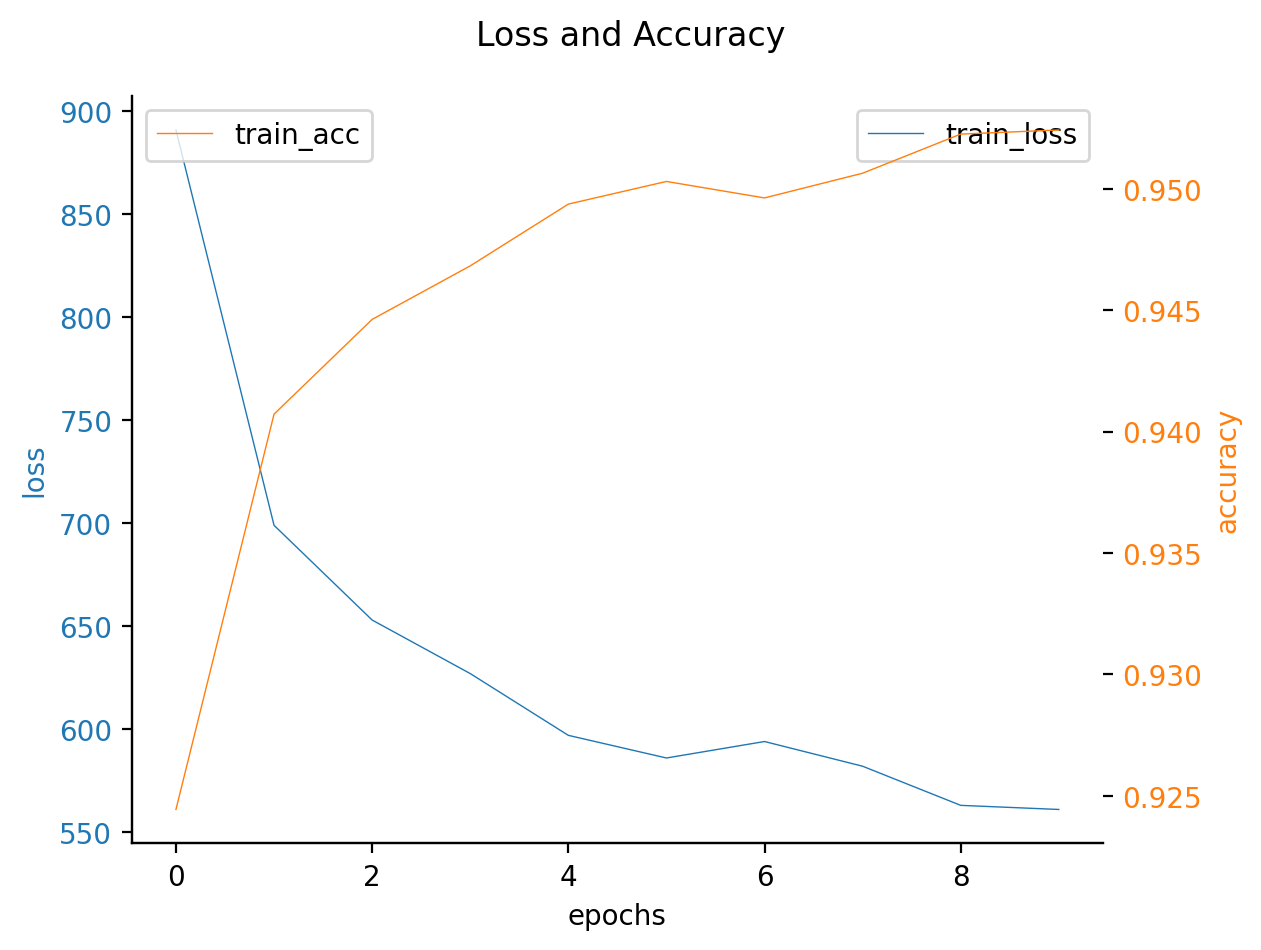

In [65]:
plot_metrics(train_metrics)

In [66]:
binary_index = np.isin(test_labels, binary_compare_labels)
binary_test_labels = test_labels[binary_index]
binary_test_images = test_images[binary_index]

In [67]:
def eval(
    X_test: np.ndarray,
    y_test: np.ndarray,
    weights: np.ndarray,
    # random_weight: np.ndarray,
    bias_size: int = 1,
) -> tuple:
    """eval evaluates the perceptron using the test data.

    Args:
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
        weights (np.ndarray): weights
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        tuple: accuracy and predictions
    """

    # initialize predictions
    predictions = np.zeros(X_test.shape[0])

    # iterate over the test data
    for i, image in enumerate(X_test):
        transformed_image = normalize(image, 0, 1).round(decimals=0).flatten()
        # transformed_image = np.dot(transformed_image, random_weight) # omitted random connections
        prediction = predict(transformed_image, weights, bias_size)
        predictions[i] = prediction

    # calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)

    return accuracy, predictions


# evaluate the perceptron
accuracy, predictions = eval(
    binary_test_images, binary_test_labels, weights, bias_size=1
)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.959


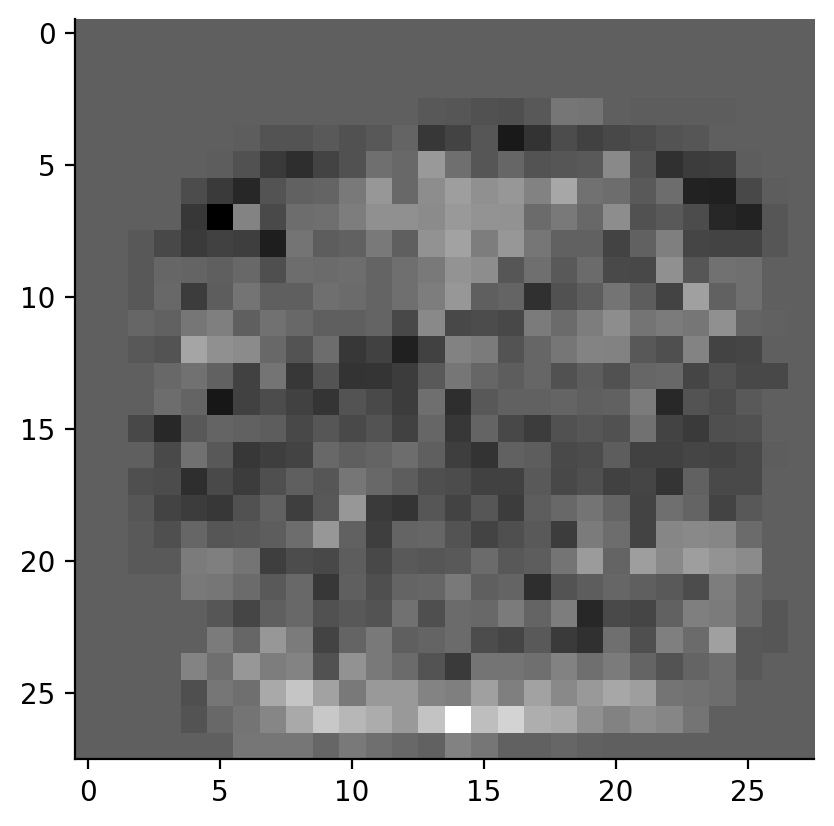

In [68]:
plt.imshow(weights[:-1].reshape(28, 28), cmap="gray")
plt.show()

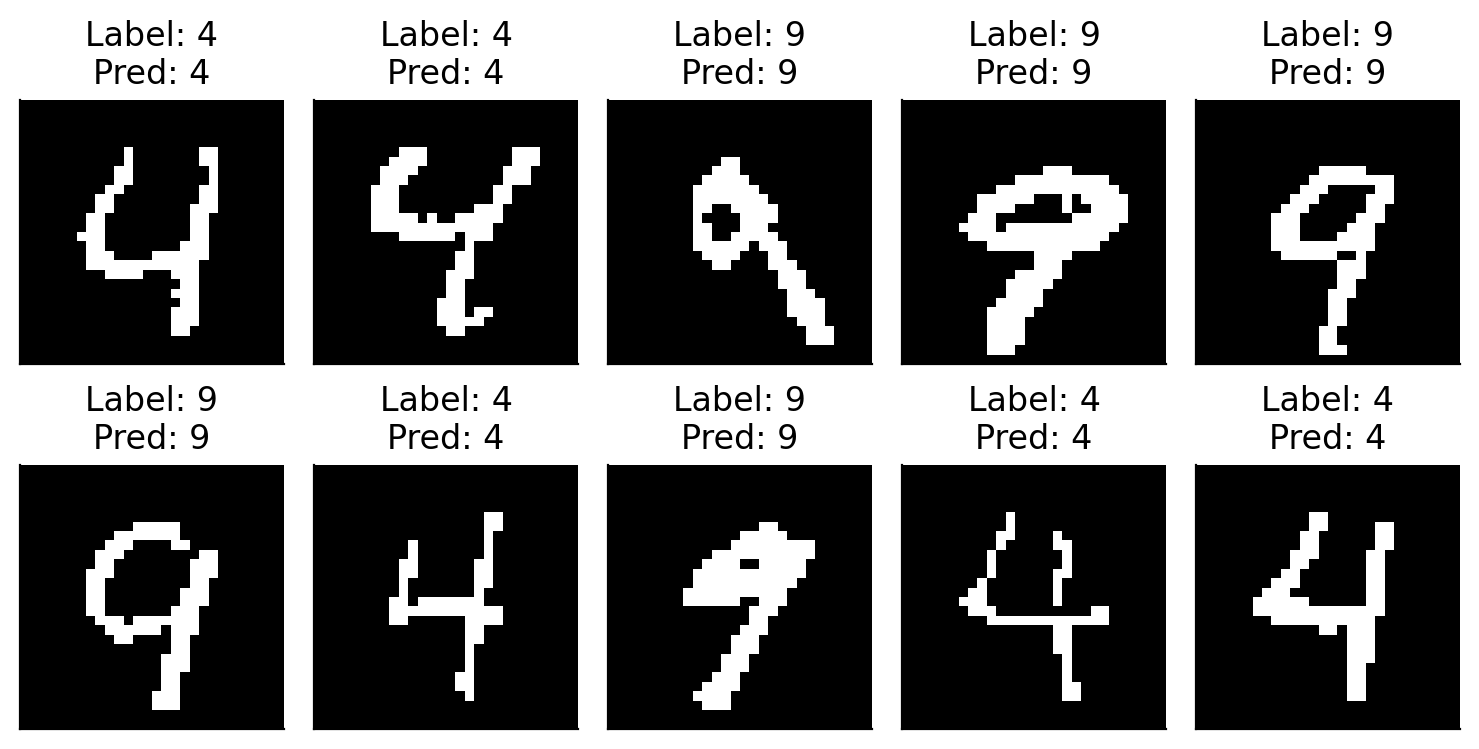

In [69]:
plot_examples(
    normalize(binary_test_images[:10], 0, 1).round(decimals=0),
    labels=binary_test_labels[:10],
    predictions=[
        predict(
            normalize(image, 0, 1).round(decimals=0).flatten(), weights, bias_size=1
        )
        for image in binary_test_images[:10]
    ],
)

## Multiclass Perceptron on MNIST

Now we can implement the perceptron as a multi-class classifier to classify all digits from 0 to 9. We can use the same training logic as before, but we need to change the calculation of the metrics as well as the dimensions of the weights and biases. At least I change the binary step function to a argmax function to get the prediction with the highest probability.

In [70]:
# initialize the weights

w_len = train_images[0].flatten().shape[0]
bias_size = 1
n_classes = np.unique(train_labels).shape[0]

weights = np.zeros((n_classes, w_len + bias_size))

print(f"Shape of weights: {weights.shape}")  # weights[0].shape
print(f"Number of classes: {n_classes}")  # weights[0].shape

Shape of weights: (10, 785)
Number of classes: 10


In [43]:
transformed_image = normalize(train_images[0], 0, 1).round(decimals=0).flatten()
predicted_value = predict(transformed_image, weights)
print(predicted_value)

0


In [44]:
# Example usage
new_weights, loss = backward_pass(
    transformed_image, weights, train_labels[0], learning_rate=0.1, bias_size=1
)

# Print the updated weights in the same shape as the image
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[0][:-bias_size].reshape(28, -1))

print(weights.shape)

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1  0.  -0.1 -0.1 -0.1 -0.1  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.   0.   0.   0. ]

The perceptron predicted zero while the actual class was a five (the output of weigts[0] had the biggest sum, which was wrong and should be on weights[5]). Therefore the weights are in such way updated, that false positives of fives are punished on weights[0], wich is visible with a reshaped version of weights[0] (above). Lets have a look at the fifth weight. Guess how it looks ;-)

In [45]:
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[5][:-bias_size].reshape(28, -1))

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.1 0.1 0.1 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.

yes! here we see that the weights for the correct class (5) are increased. Which illustrates how the backward pass works.

In [46]:
# train the perceptron
weights, train_metrics = train(
    train_images, train_labels, epochs=10, learning_rate=0.01, bias_size=1
)

Epoch 0: Loss: 10269.0000, Accuracy: 0.8288
Epoch 1: Loss: 8861.0000, Accuracy: 0.8523
Epoch 2: Loss: 8454.0000, Accuracy: 0.8591
Epoch 3: Loss: 8252.0000, Accuracy: 0.8625
Epoch 4: Loss: 8156.0000, Accuracy: 0.8641
Epoch 5: Loss: 8083.0000, Accuracy: 0.8653
Epoch 6: Loss: 8009.0000, Accuracy: 0.8665
Epoch 7: Loss: 7828.0000, Accuracy: 0.8695
Epoch 8: Loss: 7852.0000, Accuracy: 0.8691
Epoch 9: Loss: 7886.0000, Accuracy: 0.8686


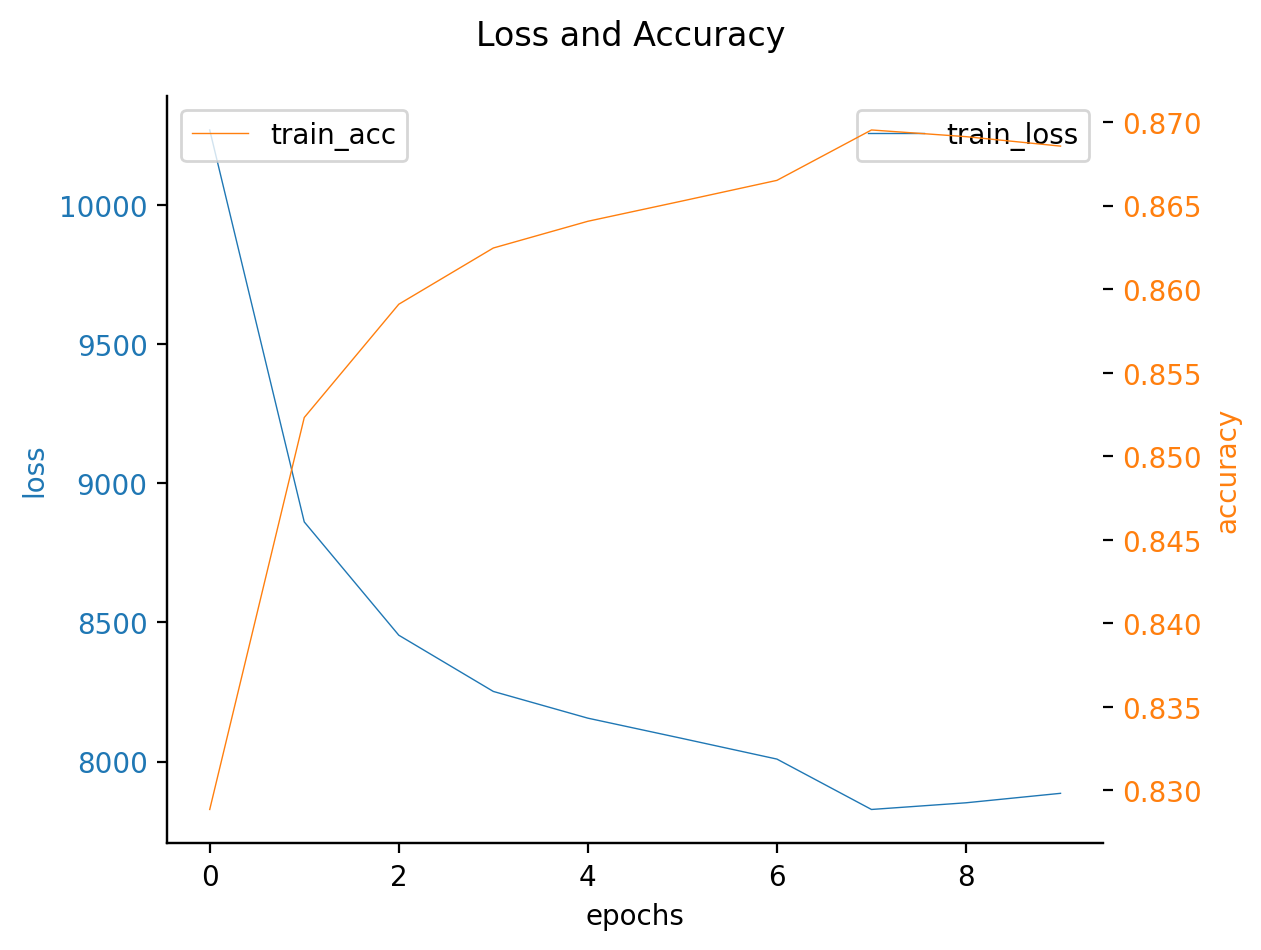

In [47]:
plot_metrics(train_metrics)

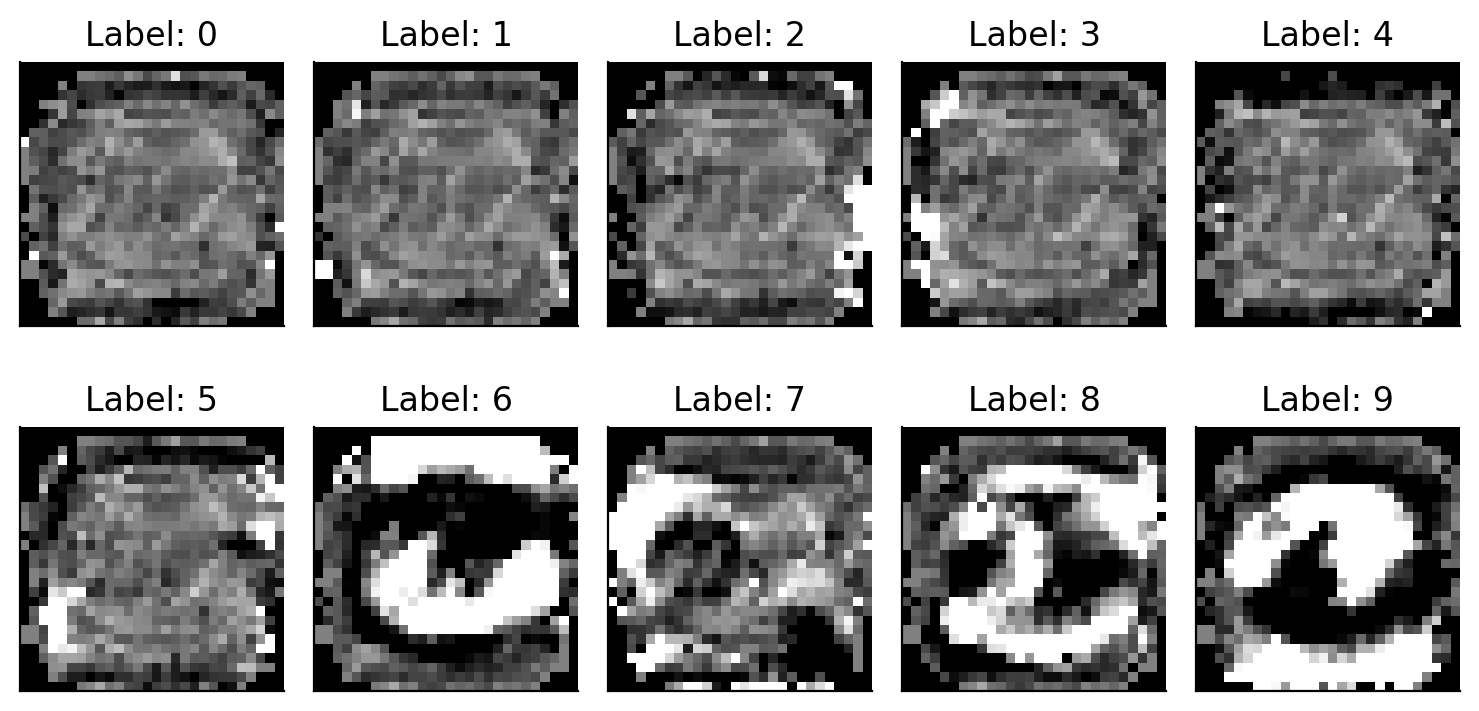

In [48]:
# Let's inspect the weights / latent space of the perceptron for each class
# we can visualize the weights as images

plot_examples(
    [weight[:-bias_size].reshape(28, -1) for weight in normalize(weights, 0, 1)],
    labels=np.arange(len(weights)),
)

In [49]:
accuracy, predictions = eval(test_images, test_labels, weights, bias_size=1)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.878


Nice an accuracy over 0.85 is for a single layer network not that bad. Let's have a look at some examples.

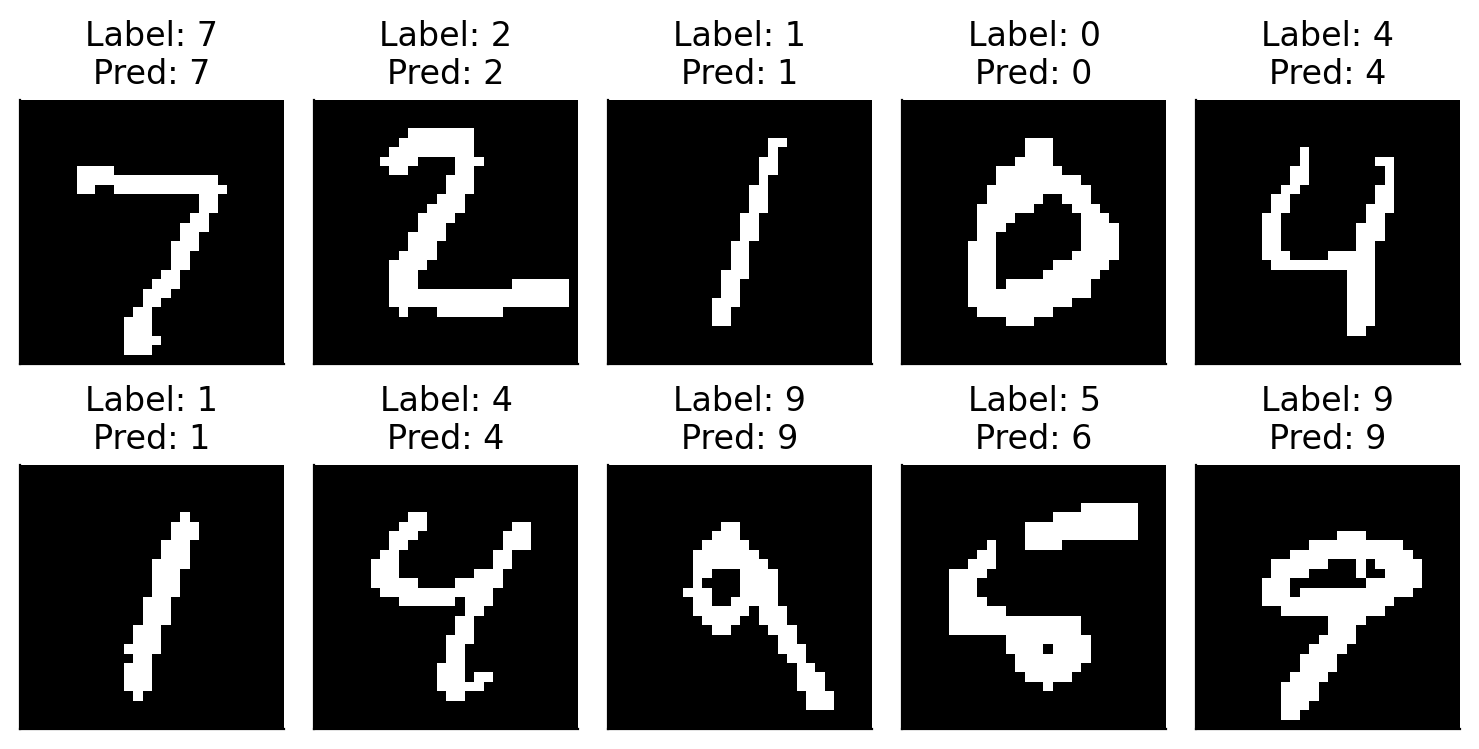

In [50]:
plot_examples(
    normalize(test_images[:10], 0, 1).round(decimals=0),
    labels=test_labels[:10],
    predictions=[
        predict(
            normalize(image, 0, 1).round(decimals=0).flatten(), weights, bias_size=1
        )
        for image in test_images[:10]
    ],
)